In [1]:
import os
import warnings
import tqdm
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
%load_ext autoreload
%autoreload 2
import socceraction.spadl as spadl
import socceraction.vaep.formula as vaepformula

## Select data

In [3]:
# Configure file and folder names
datafolder = "../data-fifa"
spadl_h5 = os.path.join(datafolder, "spadl-statsbomb.h5")
predictions_h5 = os.path.join(datafolder, "predictions.h5")

In [4]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    players = spadlstore["players"]
    teams = spadlstore["teams"]
print("nb of games:", len(games))

nb of games: 64


## Compute VAEP values

In [5]:
A = []
for game in tqdm.tqdm(list(games.itertuples()), desc="Rating actions"):
    actions = pd.read_hdf(spadl_h5, f"actions/game_{game.game_id}")
    actions = (
        spadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left")
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
    )
    preds = pd.read_hdf(predictions_h5, f"game_{game.game_id}")
    values = vaepformula.value(actions, preds.scores, preds.concedes)
    A.append(pd.concat([actions, preds, values], axis=1))
A = pd.concat(A).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)
A.columns

Rating actions: 100%|██████████████████████████████████████████████████████████████████| 64/64 [00:03<00:00, 16.20it/s]


Index(['game_id', 'original_event_id', 'period_id', 'time_seconds', 'team_id',
       'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'type_id',
       'result_id', 'bodypart_id', 'action_id', 'type_name', 'result_name',
       'bodypart_name', 'player_name', 'nickname', 'team_name', 'scores',
       'concedes', 'offensive_value', 'defensive_value', 'vaep_value'],
      dtype='object')

## Analyse VAEP ratings
### Most valuable players

In [6]:
A["count"] = 1

# Compute each player's number of actions and total VAEP values
playersR = (
    A[["player_id", "vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)
# Add player names
playersR = playersR.merge(players[["player_id", "nickname", "player_name"]], how="left")
playersR["player_name"] = playersR[["nickname","player_name"]].apply(lambda x: x.iloc[0] if x.iloc[0] else x.iloc[1], axis=1)
# Show results
playersR = playersR[["player_id", "player_name", "vaep_value", "offensive_value", "defensive_value", "count"]]
playersR.sort_values("vaep_value", ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count
152,5186.0,Denis Cheryshev,3.115112,4.001186,-0.886074,215
6,3009.0,Kylian Mbappé,3.100883,3.391557,-0.290674,491
92,3621.0,Eden Hazard,3.051791,3.369141,-0.317350,688
17,3089.0,Kevin De Bruyne,2.853646,3.167105,-0.313459,715
599,20004.0,Paul Pogba,2.694893,2.817734,-0.122841,675
50,3308.0,Kieran Trippier,2.682549,3.203740,-0.521191,685
71,3501.0,Philippe Coutinho,2.658257,2.623230,0.035027,701
121,4319.0,Edinson Cavani,2.657941,2.773171,-0.115230,225
352,5574.0,Toni Kroos,2.615233,2.757993,-0.142760,642
525,6196.0,Yerry Mina,2.441976,2.558236,-0.116260,324


In [7]:
# Normalize for minutes played
pg = pd.read_hdf(spadl_h5, "player_games")
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats = stats[stats.minutes_played > 180] # at least two full games played
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_rating"] = stats.offensive_value * 90 / stats.minutes_played
stats["defensive_rating"] = stats.defensive_value * 90 / stats.minutes_played
stats.sort_values("vaep_rating",ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
152,5186.0,Denis Cheryshev,3.115112,4.001186,-0.886074,215,317,0.884417,1.135983,-0.251567
352,5574.0,Toni Kroos,2.615233,2.757993,-0.142760,642,295,0.797868,0.841422,-0.043554
251,5473.0,Ahmed Musa,1.769203,1.822363,-0.053160,164,224,0.710840,0.732199,-0.021359
121,4319.0,Edinson Cavani,2.657941,2.773171,-0.115230,225,362,0.660814,0.689462,-0.028648
525,6196.0,Yerry Mina,2.441976,2.558236,-0.116260,324,374,0.587641,0.615618,-0.027977
451,5674.0,Moussa Wagué,1.635671,1.649539,-0.013868,169,257,0.572803,0.577660,-0.004856
34,3237.0,Sergio Agüero,1.418034,1.395863,0.022171,137,243,0.525198,0.516986,0.008211
71,3501.0,Philippe Coutinho,2.658257,2.623230,0.035027,701,458,0.522365,0.515482,0.006883
6,3009.0,Kylian Mbappé,3.100883,3.391557,-0.290674,491,559,0.499248,0.546047,-0.046799
92,3621.0,Eden Hazard,3.051791,3.369141,-0.317350,688,551,0.498478,0.550313,-0.051836


### (optional) inspect Belgium's top 10 most valuable non-shot actions

2018-06-28 20:00:00 England 0-1 Belgium 9' dribble Michy Batshuayi Tunga


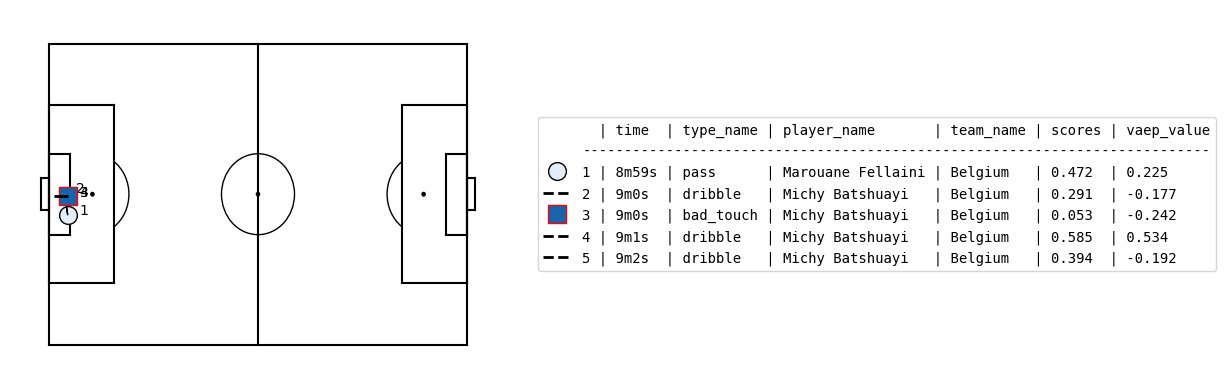

2018-07-10 20:00:00 France 1-0 Belgium 46' pass Axel Witsel


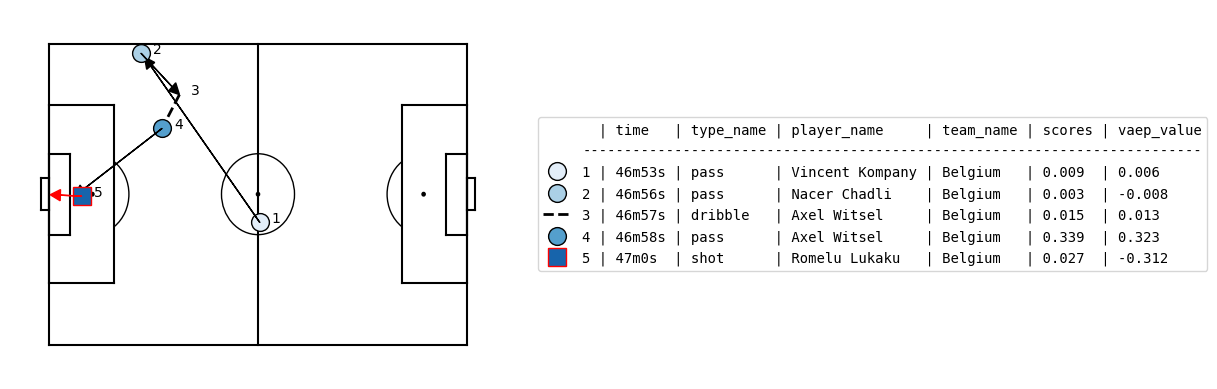

2018-06-23 14:00:00 Belgium 5-2 Tunisia 91' take_on Michy Batshuayi Tunga


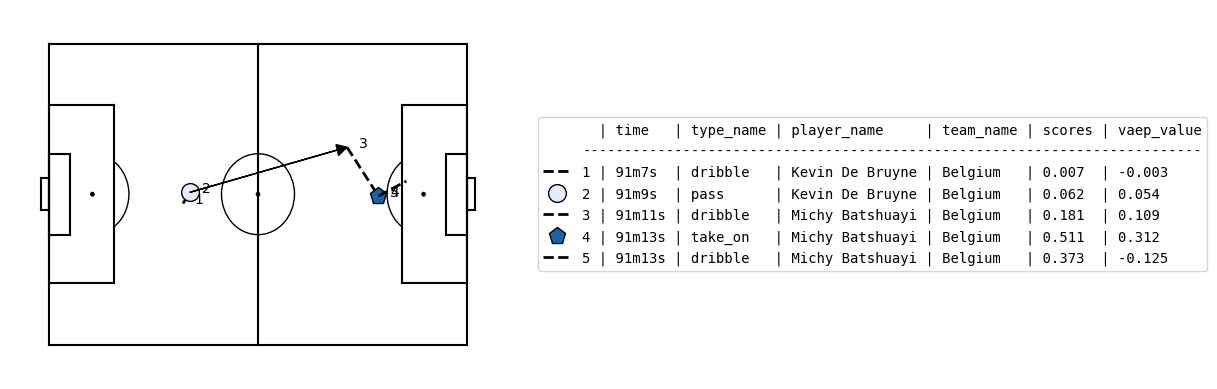

2018-07-02 20:00:00 Belgium 3-2 Japan 73' cross Eden Hazard


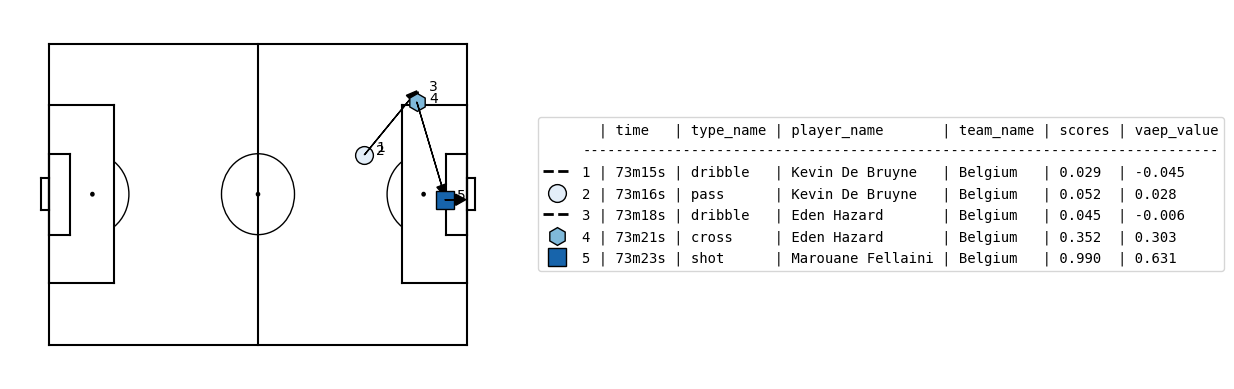

2018-06-23 14:00:00 Belgium 5-2 Tunisia 89' cross Youri Tielemans


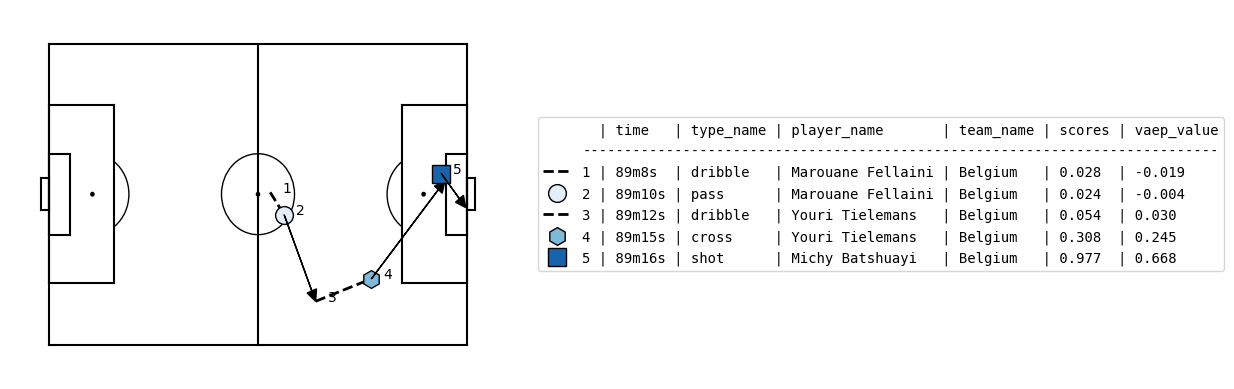

2018-06-18 17:00:00 Belgium 3-0 Panama 68' pass Kevin De Bruyne


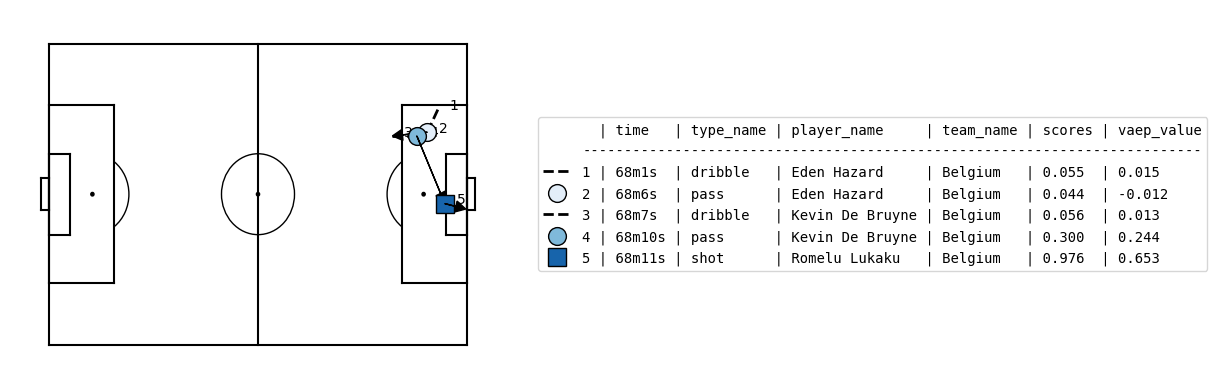

2018-06-23 14:00:00 Belgium 5-2 Tunisia 47' pass Thomas Meunier


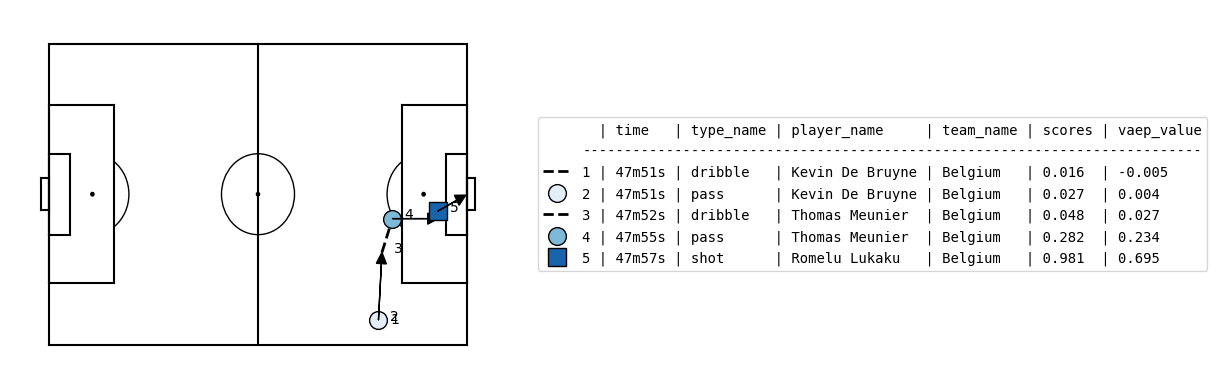

2018-06-28 20:00:00 England 0-1 Belgium 8' pass Marouane Fellaini-Bakkioui


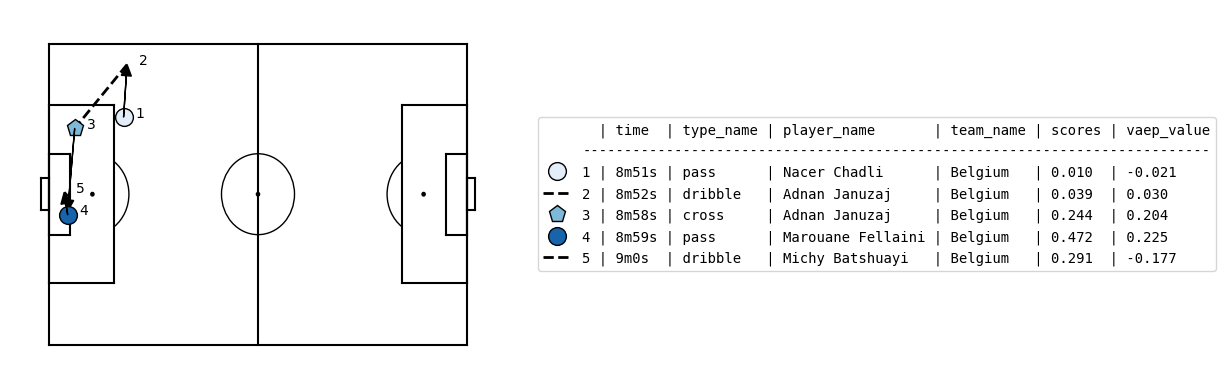

2018-07-02 20:00:00 Belgium 3-2 Japan 93' pass Thomas Meunier


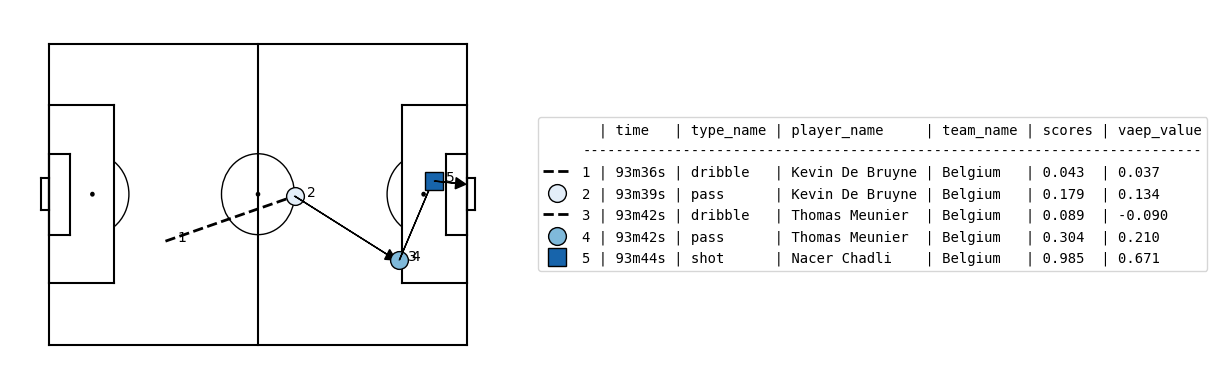

2018-07-14 16:00:00 Belgium 2-0 England 3' cross Nacer Chadli


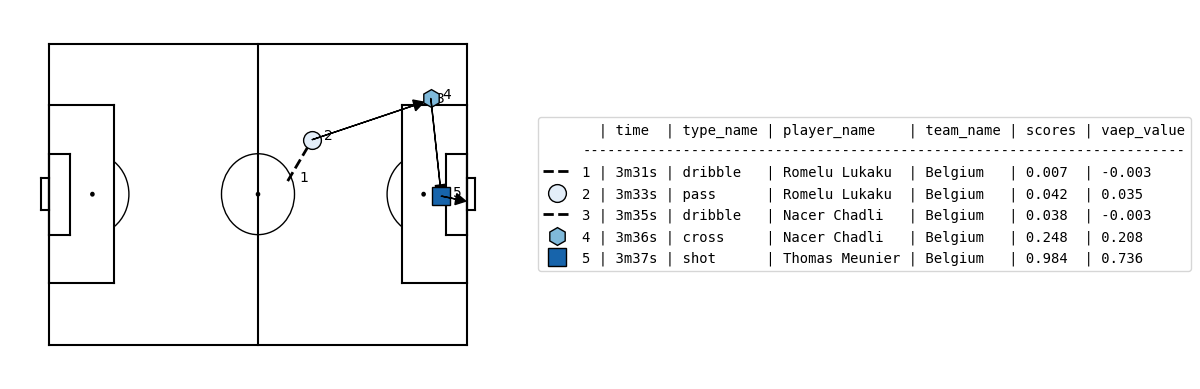

In [8]:
import matplotsoccer

sorted_A = A.sort_values("vaep_value", ascending=False)
sorted_A = sorted_A[sorted_A.team_name == "Belgium"] # view only actions from Belgium
sorted_A = sorted_A[~sorted_A.type_name.str.contains("shot")] #eliminate shots

def get_time(period_id,time_seconds):
    m = int((period_id-1)*45 + time_seconds // 60)
    s = int(time_seconds % 60)
    return f"{m}m{s}s"

for j in range(0, 10):
    row = list(sorted_A[j:j+1].itertuples())[0]
    i = row.Index
    a = A[i - 3 : i+2].copy()
    
    a["player_name"] = a[["nickname", "player_name"]].apply(lambda x: x.iloc[0] if x.iloc[0] else x.iloc[1], axis=1)
    
    g = list(games[games.game_id == a.game_id.values[0]].itertuples())[0]
    game_info = f"{g.game_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name}"
    minute = int((row.period_id-1)*45 + row.time_seconds // 60)
    print(f"{game_info} {minute}' {row.type_name} {row.player_name}")

    a["scores"] = a.scores.apply(lambda x : "%.3f" % x )
    a["vaep_value"] = a.vaep_value.apply(lambda x : "%.3f" % x )
    a["time"] = a[["period_id", "time_seconds"]].apply(lambda x: get_time(*x),axis=1)
    cols = ["time", "type_name", "player_name", "team_name", "scores", "vaep_value"]
    matplotsoccer.actions(a[["start_x", "start_y", "end_x",  "end_y"]],
                a.type_name,
                team=a.team_name,
                result = a.result_name == "success",
                label=a[cols],
                labeltitle = cols,
                zoom=False)